# Fiesole

This project aims to demonstrate the feasibility of Vertical-Federated-Learning CNN architectures.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
BATCH_SIZE = 32
MNIST_CLASSES = 10
LEARNING_RATE = 0.001
ALL_HANDS_ON_DECK = 10


In [3]:
class QuadrantTransform:
    def __init__(self, quadrant):
        assert quadrant in [
            "tl",
            "tr",
            "bl",
            "br",
        ], "Invalid quadrant. Choose from 'tl', 'tr', 'bl', 'br'"
        self.quadrant = quadrant

    def __call__(self, img):
        # Convert PIL image to tensor
        tensor = transforms.ToTensor()(img)

        # Create a blank (transparent) tensor of the same shape
        blank = torch.zeros_like(tensor)

        # Generate ambient noise
        noise = torch.rand(tensor.shape)

        if self.quadrant == "tl":
            blank[:, :14, :14] = tensor[:, :14, :14]
            blank[:, :14, 14:] = noise[:, :14, 14:]
            blank[:, 14:, :14] = noise[:, 14:, :14]
            blank[:, 14:, 14:] = noise[:, 14:, 14:]
        elif self.quadrant == "tr":
            blank[:, :14, 14:] = tensor[:, :14, 14:]
            blank[:, :14, :14] = noise[:, :14, :14]
            blank[:, 14:, 14:] = noise[:, 14:, 14:]
            blank[:, 14:, :14] = noise[:, 14:, :14]
        elif self.quadrant == "bl":
            blank[:, 14:, :14] = tensor[:, 14:, :14]
            blank[:, :14, :14] = noise[:, :14, :14]
            blank[:, 14:, 14:] = noise[:, 14:, 14:]
            blank[:, :14, 14:] = noise[:, :14, 14:]
        elif self.quadrant == "br":
            blank[:, 14:, 14:] = tensor[:, 14:, 14:]
            blank[:, :14, 14:] = noise[:, :14, 14:]
            blank[:, 14:, :14] = noise[:, 14:, :14]
            blank[:, :14, :14] = noise[:, :14, :14]

        return blank


In [4]:
transform_tl = transforms.Compose([QuadrantTransform("tl")])
transform_tr = transforms.Compose([QuadrantTransform("tr")])
transform_bl = transforms.Compose([QuadrantTransform("bl")])
transform_br = transforms.Compose([QuadrantTransform("br")])

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

trainset_tl = torchvision.datasets.MNIST(
    root="./control", train=True, download=True, transform=transform_tl
)
trainset_tr = torchvision.datasets.MNIST(
    root="./control", train=True, download=True, transform=transform_tr
)
trainset_bl = torchvision.datasets.MNIST(
    root="./control", train=True, download=True, transform=transform_bl
)
trainset_br = torchvision.datasets.MNIST(
    root="./control", train=True, download=True, transform=transform_br
)

trainloader_tl = torch.utils.data.DataLoader(trainset_tl, batch_size=4)
trainloader_tr = torch.utils.data.DataLoader(trainset_tr, batch_size=4)
trainloader_bl = torch.utils.data.DataLoader(trainset_bl, batch_size=4)
trainloader_br = torch.utils.data.DataLoader(trainset_br, batch_size=4)


testset = torchvision.datasets.MNIST(
    root="./control", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc_relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(-1, 64 * 7 * 7)

        x = self.fc1(x)
        x = self.fc_relu1(x)
        x = self.fc2(x)
        return x


In [6]:
model = CNN()

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()


In [7]:
import matplotlib.pyplot as plt


def visualize_mnist_digit_horizontally(digits):
    fig, axs = plt.subplots(1, len(digits))
    for i, digit in enumerate(digits):
        if digit.shape != (28, 28):
            digit = digit.reshape(28, 28)
        axs[i].imshow(digit, cmap="gray")
        axs[i].axis("off")  # hide the axis
    plt.show()


def example(trainset_tl, trainset_tr, trainset_bl, trainset_br):
    data_idx = torch.randint(0, len(trainset_tl), (1,)).item()

    digits = [
        trainset_tl[data_idx][0],
        trainset_tr[data_idx][0],
        trainset_bl[data_idx][0],
        trainset_br[data_idx][0],
    ]

    visualize_mnist_digit_horizontally(digits)
    print(trainset_tl[data_idx][1])


In [8]:
def test_model(debug_string, model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(debug_string, correct / total)
    return correct / total


# Training loop
def train_model(model, trainloader, optimizer):
    num_epochs = 1
    model.train()
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(trainloader):
            if torch.cuda.is_available():
                model = model.cuda()
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


def average_weights(*models):
    """Averages the weights of the given models."""
    avg_dict = {}

    # Get the state dictionary of the first model to initialize the avg_dict
    for key in models[0].state_dict().keys():
        avg_dict[key] = sum([model.state_dict()[key] for model in models]) / len(models)

    return avg_dict


In [9]:
import copy

tl_history = []
tr_history = []
bl_history = []
br_history = []
avg_history = []


def federated_learning(original_model):
    model_tl = copy.deepcopy(original_model)
    optimizer_tl = optim.Adam(model_tl.parameters(), lr=LEARNING_RATE)
    model_tr = copy.deepcopy(original_model)
    optimizer_tr = optim.Adam(model_tr.parameters(), lr=LEARNING_RATE)
    model_bl = copy.deepcopy(original_model)
    optimizer_bl = optim.Adam(model_bl.parameters(), lr=LEARNING_RATE)
    model_br = copy.deepcopy(original_model)
    optimizer_br = optim.Adam(model_br.parameters(), lr=LEARNING_RATE)

    transform_tl = transforms.Compose([QuadrantTransform("tl")])
    transform_tr = transforms.Compose([QuadrantTransform("tr")])
    transform_bl = transforms.Compose([QuadrantTransform("bl")])
    transform_br = transforms.Compose([QuadrantTransform("br")])

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    trainset_tl = torchvision.datasets.MNIST(
        root="./control", train=True, download=True, transform=transform_tl
    )
    trainset_tr = torchvision.datasets.MNIST(
        root="./control", train=True, download=True, transform=transform_tr
    )
    trainset_bl = torchvision.datasets.MNIST(
        root="./control", train=True, download=True, transform=transform_bl
    )
    trainset_br = torchvision.datasets.MNIST(
        root="./control", train=True, download=True, transform=transform_br
    )

    trainloader_tl = torch.utils.data.DataLoader(trainset_tl, batch_size=4)
    trainloader_tr = torch.utils.data.DataLoader(trainset_tr, batch_size=4)
    trainloader_bl = torch.utils.data.DataLoader(trainset_bl, batch_size=4)
    trainloader_br = torch.utils.data.DataLoader(trainset_br, batch_size=4)

    example(trainset_tl, trainset_tr, trainset_bl, trainset_br)

    train_model(model_tl, trainloader_tl, optimizer_tl)
    tl_history.append(test_model("TL", model_tl))

    train_model(model_tr, trainloader_tr, optimizer_tr)
    tr_history.append(test_model("TR", model_tr))

    train_model(model_bl, trainloader_bl, optimizer_bl)
    bl_history.append(test_model("BL", model_bl))

    train_model(model_br, trainloader_br, optimizer_br)
    br_history.append(test_model("BR", model_br))

    avg_state_dict = average_weights(model_tl, model_tr, model_bl, model_br)

    new_model = CNN()
    new_model.load_state_dict(avg_state_dict)

    if torch.cuda.is_available():
        new_model = new_model.cuda()

    avg_history.append(test_model("avg", new_model))
    return new_model


Iteration 1


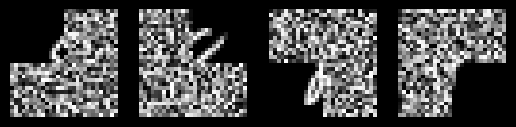

8
TL 0.1251
TR 0.2372
BL 0.3643
BR 0.3973
avg 0.3536
Iteration 2


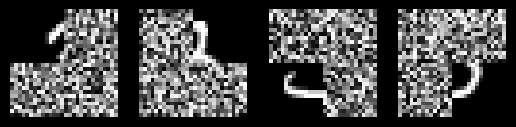

3
TL 0.1857
TR 0.3085
BL 0.407
BR 0.4873
avg 0.4087
Iteration 3


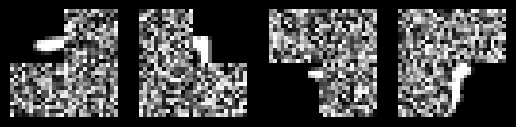

7
TL 0.2794
TR 0.1875
BL 0.3318
BR 0.3834
avg 0.4354
Iteration 4


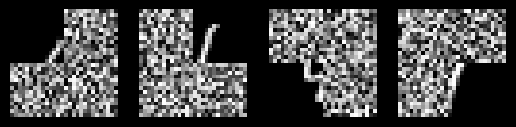

4
TL 0.3102
TR 0.4513
BL 0.3113
BR 0.3347
avg 0.4641
Iteration 5


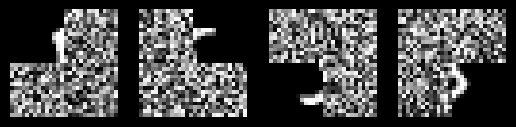

5
TL 0.1593
TR 0.2881
BL 0.3854
BR 0.3992
avg 0.3735
Iteration 6


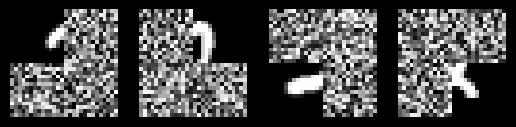

2
TL 0.1989
TR 0.3415
BL 0.2961
BR 0.4125
avg 0.3119
Iteration 7


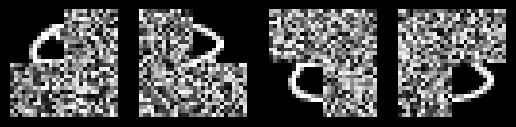

8
TL 0.1119
TR 0.31
BL 0.3286
BR 0.4111
avg 0.2495
Iteration 8


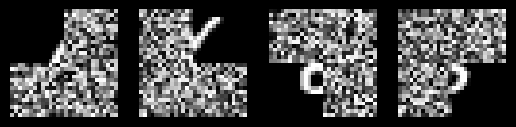

6
TL 0.1141
TR 0.2852
BL 0.2233
BR 0.2696
avg 0.2411
Iteration 9


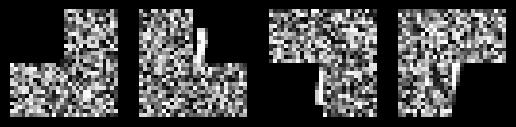

1
TL 0.098
TR 0.2343
BL 0.205
BR 0.2708
avg 0.2408
Iteration 10


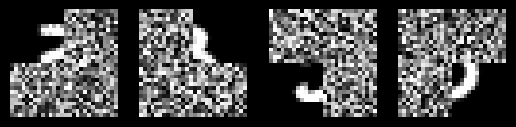

3
TL 0.0974
TR 0.1852
BL 0.1877
BR 0.3236
avg 0.2284


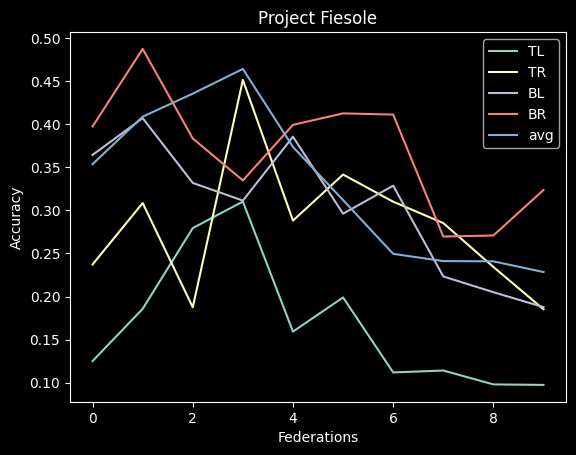

In [10]:
for i in range(ALL_HANDS_ON_DECK):
    print(f"Iteration {i+1}")
    model = federated_learning(model)

# Plot the results
plt.plot(tl_history, label="TL")
plt.plot(tr_history, label="TR")
plt.plot(bl_history, label="BL")
plt.plot(br_history, label="BR")
plt.plot(avg_history, label="avg")
plt.legend()
plt.xlabel("Federations")
plt.ylabel("Accuracy")
plt.title("Project Fiesole")
import datetime

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plt.savefig("fiesole-ambient-" + current_time + ".png")

plt.show()


torch.save(model.state_dict(), "fiesole.ckpt")
